In [1]:
# first draw tokens distribution:

import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pickle

def update_x(x):
    if x == ' ':
        return '\\s'
    elif x == '\n':
        return '\\n'
    return x


meta_path = 'nanoGPT/data/shakespeare_char/meta.pkl'
load_meta = os.path.exists(meta_path)
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data_dir = 'nanoGPT/data/shakespeare_char'
data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')

counter = Counter(data)
counts = np.array(sorted(counter.values(), reverse=True))

decoded_tokens = list(counter.items())
decoded_tokens = sorted(decoded_tokens, key=lambda x: x[1], reverse=True)
decoded_tokens = [int(x[0]) for x in decoded_tokens]
decoded_tokens = list(decode(decoded_tokens))

decoded_tokens = [update_x(x) for x in decoded_tokens]

/tmp/ipykernel_51418/2531298960.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dicts = {name: torch.load(path) for name, path in state_dict_paths.items()}


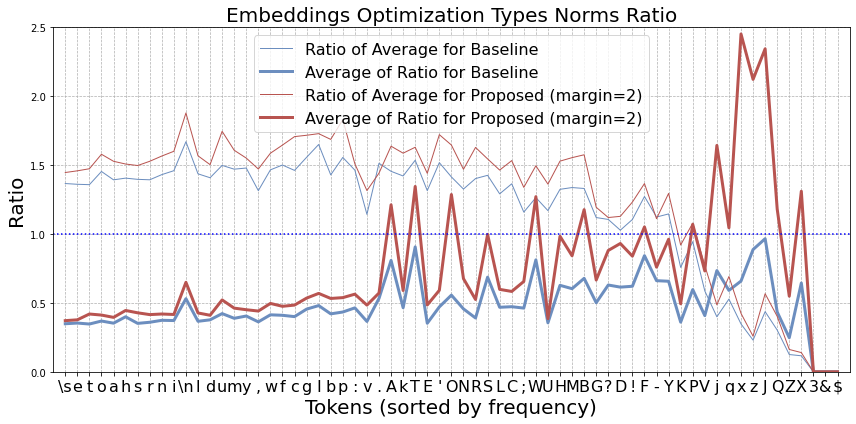

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

state_dict_paths = {
    'baseline': 'nanoGPT/out/baseline_logged/grad_logger_state_dict.pth',
    'margin_2': 'nanoGPT/out/proposed_margin_2.0_logged/grad_logger_state_dict.pth'
}
key_1 = 'grad_input'
key_2_1 = 'grad_output_positive'
key_2_2 = 'grad_output_negative'

state_dicts = {name: torch.load(path) for name, path in state_dict_paths.items()}
               
numpy_arrays_dict = {}
for name, state_dict in state_dicts.items():
    numpy_arrays_dict[name] = {k: v.detach().numpy() for k, v in state_dict.items()}

sorted_tokens = [token for token, _ in counter.most_common()]

plt.figure(figsize=(12, 6))

colors = {
    'baseline': '#6C8EBF',
    'margin_2': '#B85450',
}

name2label = {
    'baseline': 'Baseline',
    'margin_2': 'Proposed (margin=2)',
}

def get_micro_ratio(a):
    
    # Calculate the sum of the gradients across all steps for each token_id (from the averaged data)
    micro_ratio = []
    for i in range(130):
        u = (a[key_1][:, i] + a[key_2_1][:, i])
        d = a[key_2_2][:, i]
        mr_1 = u[d > 0] / d[d > 0]
        mr_0 = u[d < 0] / (d[d > 0].mean() / 10)
        mr = np.hstack((mr_1, mr_0)).mean()
        micro_ratio.append(mr)
    micro_ratio = np.array(micro_ratio)
    return micro_ratio

macro_ratios = {}
micro_ratios = {}
for name, a in numpy_arrays_dict.items():
    macro_ratios[name] = (a[key_1].mean(axis=0) + a[key_2_1].mean(axis=0)) / (a[key_2_2].mean(axis=0))
    micro_ratios[name] = get_micro_ratio(a)
    plt.plot(macro_ratios[name][65:][sorted_tokens],
             label=f'Ratio of Average for {name2label[name]}', color=colors[name], linewidth=1)
    plt.plot(micro_ratios[name][65:][sorted_tokens], # linestyle='--', 
             label=f'Average of Ratio for {name2label[name]}', color=colors[name], linewidth=3)
#     plt.plot(macro_ratios[name][:65][sorted_tokens],
#              label=f'{name} (macro ratio), high-resource language', color=colors[name], linewidth=1)
#     plt.plot(micro_ratios[name][:65][sorted_tokens], linestyle='--', 
#              label=f'{name} (micro ratio), high-resource language', color=colors[name], linewidth=1)
#     plt.plot(a[key_1].mean(axis=0)[65:][sorted_tokens], linestyle='--',
#              label=f'{name} 1', color=colors[name], linewidth=2)
#     plt.plot(a[key_2_1].mean(axis=0)[65:][sorted_tokens], linestyle='-.',
#              label=f'{name} 2.1', color=colors[name], linewidth=2)
#     plt.plot((a[key_2_2].mean(axis=0))[65:][sorted_tokens], 
#              label=f'{name} 2.2', color=colors[name], linewidth=2)

plt.axhline(y = 1, color = 'b', linestyle = ':')
plt.ylabel('Ratio', fontsize=20)
# plt.yscale('log')
plt.xticks(ticks=range(len(decoded_tokens)), labels=decoded_tokens, fontsize=16)
# plt.xticks([])
plt.title('Embeddings Optimization Types Norms Ratio', fontsize=20)

plt.xlabel('Tokens (sorted by frequency)', fontsize=20)  # Add x-axis label with font size

plt.legend(fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.7) # , axis='y')

plt.xlim((-1, 65))
plt.ylim((0, 2.5))

plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("assets/optimization_ratio_comparison.pdf", format="pdf")

# Display the plot
plt.show()


In [3]:
mrb = micro_ratios['baseline'][65:]
mrp = micro_ratios['margin_2'][65:]
print((mrp[mrb!=0]/mrb[mrb!=0]).mean())

1.4558812


In [4]:
mrb = macro_ratios['baseline'][65:]
mrp = macro_ratios['margin_2'][65:]
print((mrp[mrb!=0]/mrb[mrb!=0]).mean())

1.1288095


In [18]:
np.median(numpy_arrays_dict['baseline'][key_1], axis=0)

array([0.12255196, 0.37450555, 0.01932897, 0.        , 0.        ,
       0.04231748, 0.06133893, 0.02335203, 0.03988818, 0.        ,
       0.04591205, 0.02610054, 0.01955222, 0.0382104 , 0.02482389,
       0.02980352, 0.01668305, 0.02815411, 0.01838736, 0.01894077,
       0.02436864, 0.05389789, 0.        , 0.00863945, 0.02568391,
       0.02489021, 0.0225936 , 0.0255181 , 0.01404016, 0.        ,
       0.02943345, 0.02964472, 0.03288227, 0.01367785, 0.        ,
       0.0266323 , 0.        , 0.01218864, 0.        , 0.15849875,
       0.07462119, 0.08619241, 0.08911842, 0.19283552, 0.08189303,
       0.06459685, 0.12448522, 0.14171065, 0.        , 0.04012543,
       0.11082581, 0.09009171, 0.11430278, 0.15329558, 0.07309851,
       0.        , 0.13056533, 0.13534954, 0.14646748, 0.09570429,
       0.05017072, 0.08943661, 0.        , 0.05926542, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     